In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
from tqdm import tqdm

import torchsde
from torchdyn.core import NeuralODE
import matplotlib.pyplot as plt

from torchcfm.conditional_flow_matching import *
from torchcfm.utils import sample_8gaussians, sample_moons, torch_wrapper, SDE
from torchcfm.models import MLP

savedir = "models/2d"
os.makedirs(savedir, exist_ok=True)

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/lightning_utilities/core/imports.py:93: UserWarning: Unbuilt egg for MIOFlow [unknown version] (/home/mila/a/alexander.tong/MIOFlow)
  pkg_resources.require(self.requirement)


In [2]:
def plot_trajectories_sb(traj, legend=True):
    n = 2000
    plt.figure(figsize=(10, 10))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(5, 15):
        plt.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 1.0
dim = 2
model = MLP(dim=dim, time_varying=True, w=64)
score_model = MLP(dim=dim, time_varying=True, w=64)
optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()), 0.01)
#FM = ConditionalFlowMatcher(sigma=sigma)
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)


In [4]:
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    t, xt, ut, eps = FM.sample_location_and_conditional_flow(x0, x1, return_noise=True)
    lambda_t = FM.compute_lambda(t)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    st = score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    loss = flow_loss + score_loss
    loss.backward()
    optimizer.step()


100%|██████████| 10000/10000 [06:09<00:00, 27.05it/s]


In [5]:
node = NeuralODE(
    torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
x0 = sample_8gaussians(1024)
with torch.no_grad():
    traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100).to(device),
    )

sde = SDE(model, score_model)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0,
        ts=torch.linspace(0, 1, 100),
        solver="euler",
    )

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")
/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


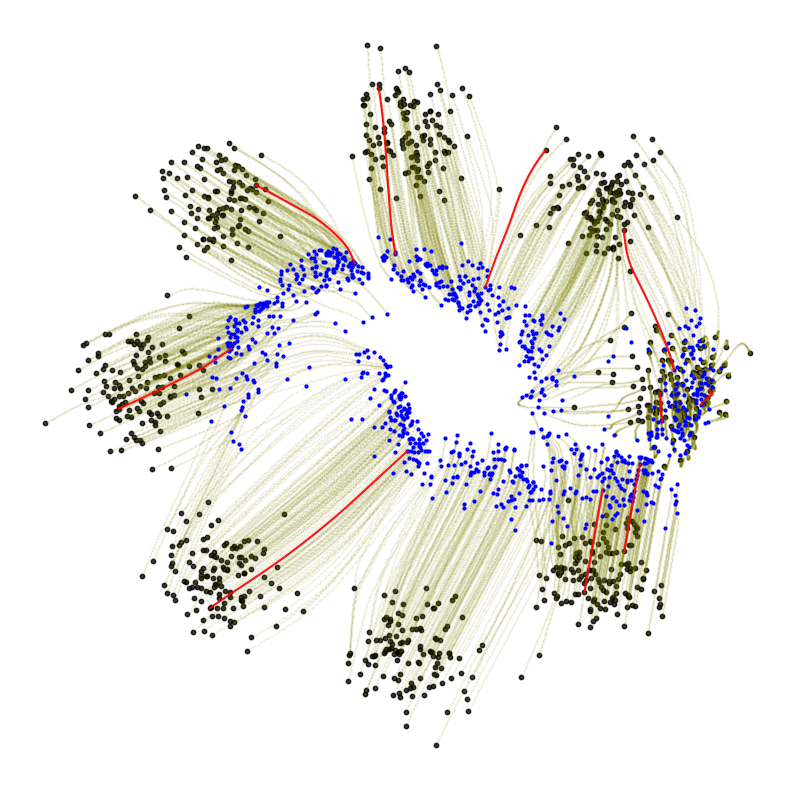

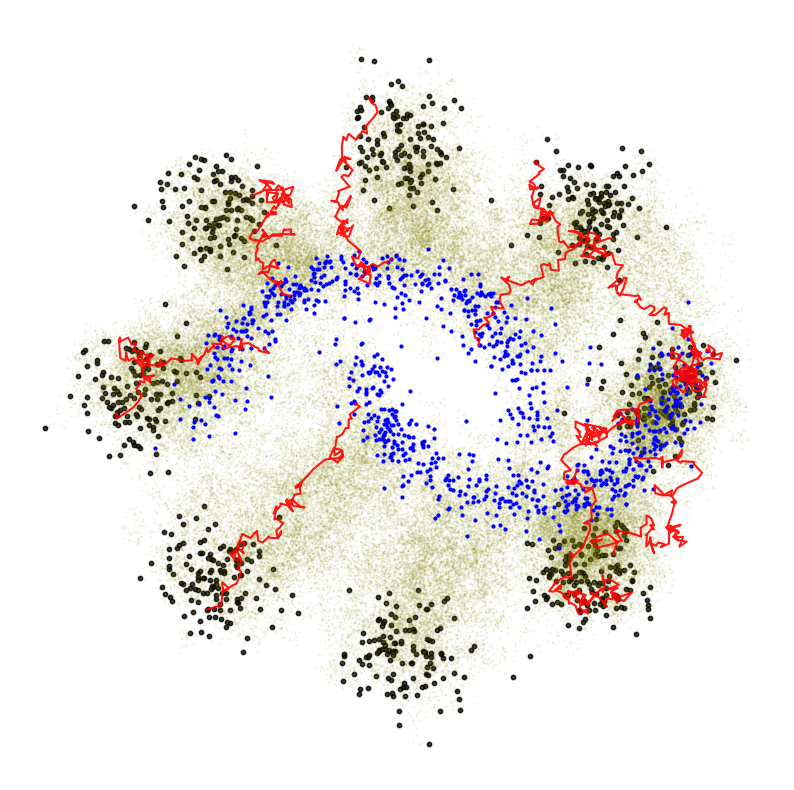

In [6]:
plot_trajectories_sb(traj, legend=False)
plot_trajectories_sb(sde_traj, legend=False)